In [56]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from tqdm.auto import tqdm
from multiprocessing import Pool
from recombinator.iid_bootstrap import iid_bootstrap
import recombinator.block_bootstrap as bb
from recombinator.optimal_block_length import optimal_block_length
from numba import njit
from functools import partial
import yfinance as yf
import sys
import os

sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1.7)


In [57]:
url = 'https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/l59c/mm23/data'


header = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
    "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)
# https://stackoverflow.com/questions/43590153/http-error-403-forbidden-when-reading-html
data = json.loads(r.text)
cpih_mnthonmnth_df = pd.json_normalize(data, record_path=['months'])
# https://towardsdatascience.com/how-to-convert-json-into-a-pandas-dataframe-100b2ae1e0d8
cpih_mnthonmnth_df = cpih_mnthonmnth_df[['date', 'value']].apply(pd.Series)
cpih_mnthonmnth_df['value'] = cpih_mnthonmnth_df['value'].astype(float)
cpih_mnthonmnth_df['value'] = 1 + cpih_mnthonmnth_df['value'] / 100

# https://stackoverflow.com/questions/65612231/convert-string-month-year-to-datetime-in-pandas-dataframe

cpih_mnthonmnth_df['date'] = pd.to_datetime(
    cpih_mnthonmnth_df['date'], format='%Y %b')
cpih_mnthonmnth_df = cpih_mnthonmnth_df.set_index(['date'])

cpih_mnthonmnth_df.tail()


,value
date,
2021-02-01,1.001
2021-03-01,1.002
2021-04-01,1.007
2021-05-01,1.005
2021-06-01,1.004


In [58]:
sp500 = yf.Ticker("IGUS.L")
hist = sp500.history(period="max", interval="1mo")
SP500_daily_returns = hist['Close'].to_frame()
SP500_daily_returns


,Close
Date,
2010-10-01,2580.0
2010-11-01,2588.0
2010-12-01,2758.0
2011-01-01,2811.0
2011-02-01,2908.5
...,...
2021-04-01,9543.0
2021-05-01,9620.0
2021-06-01,9822.0


In [59]:
sp500_cpi_df = SP500_daily_returns.pct_change()[1:]
sp500_cpi_df['Close'] = sp500_cpi_df['Close'] + 1

sp500_cpi_df = sp500_cpi_df.merge(
    cpih_mnthonmnth_df, left_index=True, right_index=True)

In [60]:
@njit()
def monthly_income(base_yrly_salary, nominal_salary_index):
    # Need to adjust so that salary adjusts yearly.
    return base_yrly_salary / 12 * nominal_salary_index


@njit()
def taxband_monthly_income(nominal_avg_salary_index, monthly_band):
    # Need to adjust so that salary adjusts yearly.
    return monthly_band * nominal_avg_salary_index


@njit()
def monthly_repayment(nominal_avg_salary_index, lower_taxband, base_yrly_salary, nominal_salary_index):
    delta_income = monthly_income(base_yrly_salary, nominal_salary_index) - \
        taxband_monthly_income(nominal_avg_salary_index, lower_taxband)
    if delta_income > 0:
        return delta_income * 0.09
    else:
        return 0


@njit()
def working_interest(nominal_avg_salary_index, lower_taxband, base_yrly_salary, nominal_salary_index):
    rpi = 1.0514448923219213  # fix this u nonce

    income = monthly_income(base_yrly_salary, nominal_salary_index)
    bottom_band = taxband_monthly_income(
        nominal_avg_salary_index, lower_taxband)
    upper_band = taxband_monthly_income(
        nominal_avg_salary_index, lower_taxband)

    delta_income = income - bottom_band
    if delta_income > 0:
        if income > upper_band:
            # daily interest rate from annual interest rate
            return (rpi + 0.03) ** (1 / 365)
        else:
            # linear interpolation with 0% at 27295 and 3% at 49130
            return (rpi + delta_income / (upper_band - bottom_band) * 0.03) ** (1 / 365)
    else:
        return 1


In [61]:
# https://www.reddit.com/r/badeconomics/comments/k9g348/what_vanguard_wont_tell_you/
def gen_bootstrap_samples(returns_df, bootstrap_replications, no_of_months, kind, block_length=10):
    # Generate bootstrap samples

    if kind == "iid":
        bootstrap_samples = iid_bootstrap(
            np.array(returns_df),
            replications=bootstrap_replications,
            sub_sample_length=no_of_months,
        )
    elif kind == "stationary":
        bootstrap_samples = bb.stationary_bootstrap(
            np.array(returns_df),
            block_length=block_length,
            replications=bootstrap_replications,
            sub_sample_length=no_of_months,
        )
    else:
        raise Exception(f'Unknown bootstrap type: {kind}')

    return bootstrap_samples


In [62]:
@njit()
def sim_portfolio(bootstrap_sample, first_payment, lower_taxband, base_yrly_salary, real_salary_mnthonmnth_growth, real_avg_salary_mnthonmnth_growth, daterange1, daterange2):
    payments = 0
    npv_payments = 0
    npv_SP500_payments = 0

    i = 0  # which month bootstrap we are on
    nominal_salary_index = 1
    nominal_avg_salary_index = 1

    # only used for NPV calculation, starts when loan is first paid out unlike the previous indices which start on first job
    cpih_index = 1
    sp500_index = 1

    # Whilst in University
    debt = 0
    rpi = 1.0514448923219213  # fix this u nonce !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    interest = (rpi + 0.03) ** (1 / 365)

    for single_date in daterange1:
        if single_date in (first_payment, "2022-02-02", "2022-10-19", "2023-02-01", "2023-10-18", "2024-01-31", "2024-10-17", "2025-01-30"):
            debt += 4422/3 + .25 * 9250
        if single_date in ("2022-05-04", "2023-05-03", "2024-05-02", "2025-05-01"):
            debt += 4422/3 + .5 * 9250

        debt = debt * interest

        if single_date[-2:] == '01':
            cpih_index *= bootstrap_sample[i, 1]
            sp500_index *= bootstrap_sample[i, 0]
            i += 1

    # After leaving University
    for single_date in daterange2:
        if single_date[-2:] == '01':
            nominal_salary_index *= real_salary_mnthonmnth_growth * bootstrap_sample[i, 1]
            nominal_avg_salary_index *= real_avg_salary_mnthonmnth_growth * bootstrap_sample[i, 1]
            # Real = Nominal / Price
            # Nominal (t + 1) = Real (t + 1) * Price (t + 1)
            # real_salary_mnthonmnth_growth = Real(t + 1) / Real (t). Real(t + 1) - Real (t) / Real(t) =  Real(t + 1) / Real(t) - 1
            # Nominal (t + 1) = Nominal(t) * Real(t + 1) / Real (t) * Price(t + 1) / Price (t)
            
            cpih_index *= bootstrap_sample[i, 1]
            sp500_index *= bootstrap_sample[i, 0]
            
            repayment = monthly_repayment(
                nominal_avg_salary_index, lower_taxband, base_yrly_salary, nominal_salary_index)
            i += 1
        else:
            repayment = 0

        # interest is accrued daily whilst repayments are monthly so can't be inside previous if
        interest = working_interest(
            nominal_avg_salary_index, lower_taxband, base_yrly_salary, nominal_salary_index)

        # if repayment > debt * interest
        repayment = min(repayment, debt * interest)
        debt = debt * interest - repayment

        payments += repayment

        npv_payments += repayment / cpih_index
        npv_SP500_payments += repayment / sp500_index

        if debt <= 0:
            # print(single_date)
            break

    #print("payments: %s, NPV: %s, NPV SP500: %s" %(payments, npv_payments, npv_SP500_payments))
    #print(".", end = '')
    return [payments, npv_payments, npv_SP500_payments]


In [63]:
def run_simulation(bootstrap_samples, first_payment, lower_taxband, base_yrly_salary, real_salary_mnthonmnth_growth, real_avg_salary_mnthonmnth_growth, daterange1, daterange2, ParallelBool, cpus):
    results = []

    run_trial = partial(
        sim_portfolio,
        first_payment=first_payment,
        lower_taxband=lower_taxband,
        base_yrly_salary=base_yrly_salary,
        real_salary_mnthonmnth_growth=real_salary_mnthonmnth_growth, real_avg_salary_mnthonmnth_growth=real_avg_salary_mnthonmnth_growth,
        daterange1=daterange1,  # check the end date
        daterange2=daterange2,
    )

    if ParallelBool:
        with Pool(cpus) as p:
            for result in tqdm(p.imap_unordered(run_trial, bootstrap_samples), total=bootstrap_samples.shape[0]):
                results.append(result)
    else:
        for each in bootstrap_samples:
            results.append(run_trial(each))

    return np.array(results)

In [64]:
from numba import prange

@njit(parallel=True)
def run_simulation_numba(bootstrap_samples, first_payment, lower_taxband, base_yrly_salary, real_salary_mnthonmnth_growth, real_avg_salary_mnthonmnth_growth, daterange1, daterange2):
    results = np.zeros((bootstrap_samples.shape[0], 3))

    for i in prange(bootstrap_samples.shape[0]):
        results[i] = sim_portfolio(bootstrap_samples[i], first_payment, lower_taxband, base_yrly_salary, real_salary_mnthonmnth_growth, real_avg_salary_mnthonmnth_growth, daterange1, daterange2)

    return results

In [65]:
"""
returns_df:           the dataframe of sp500 and cpi monthly percentage change from previous month
base_yrly_salary:     the yearly salary in the first year         
"""
base_yrly_salary = 30000
real_salary_yronyr_growth = 1.02
real_avg_salary_yronyr_growth = 1.01

real_salary_mnthonmnth_growth = real_salary_yronyr_growth ** (1 / 12)
real_avg_salary_mnthonmnth_growth = real_avg_salary_yronyr_growth ** (1 / 12)
lower_taxband = 27295 / 12
upper_taxband = 49130/12
# Day of first payment from student loan company to me, also day interest starts accruing
first_payment = "2021-10-20"
last_repayment = "2056-04-05"
start_date = pd.Timestamp(first_payment)
end_date = pd.Timestamp(last_repayment)
no_of_months = (end_date.year - start_date.year) * \
    12 + (end_date.month - start_date.month)

# check the end date
daterange1 = [d.strftime("%Y-%m-%d")
              for d in pd.date_range(first_payment, "2026-04-05")]
daterange2 = [d.strftime("%Y-%m-%d")
              for d in pd.date_range("2026-04-06", last_repayment)]

from numba.typed import List
daterange1_numba = List(daterange1)
daterange2_numba = List(daterange2)

In [66]:
print('Generating bootstrap sample...')
bootstrap_samples = gen_bootstrap_samples(
    sp500_cpi_df, 100000, no_of_months, kind='stationary', block_length=2)
# block length was 10 years in example, however that is almost all of the data

Generating bootstrap sample...


In [67]:
print('Simulating...')
#results = run_simulation(bootstrap_samples, first_payment, lower_taxband, base_yrly_salary, real_salary_mnthonmnth_growth, real_avg_salary_mnthonmnth_growth, daterange1, daterange2, 1, 8)
results = run_simulation_numba(bootstrap_samples, first_payment, lower_taxband, base_yrly_salary, real_salary_mnthonmnth_growth, real_avg_salary_mnthonmnth_growth, daterange1_numba, daterange2_numba)

Simulating...


Plot...


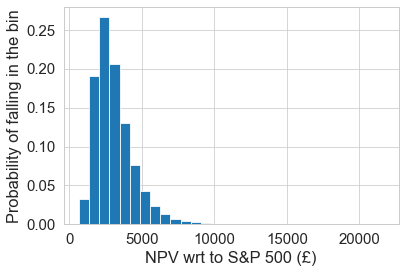

In [ ]:
print('Plot...')
#plt.hist(results[:, 2])
S = results[:, 2]
plt.hist(S, weights=np.ones_like(S) / len(S), bins=30)
plt.ylabel("Probability of falling in the bin")
plt.xlabel("NPV wrt to S&P 500 (£)")
plt.show() # not necessary, used to hide output of previous command

In [ ]:
a = np.array([2.4000e-04, 3.5700e-03, 1.8850e-02, 6.2120e-02, 1.3271e-01,
        1.9577e-01, 2.0879e-01, 1.5949e-01, 1.0199e-01, 5.8350e-02,
        3.0470e-02, 1.4490e-02, 6.7900e-03, 3.4200e-03, 1.6800e-03,
        6.1000e-04, 4.2000e-04, 1.6000e-04, 4.0000e-05, 4.0000e-05])
np.sum(a)

1.0

In [ ]:
from recombinator.optimal_block_length import optimal_block_length
b_star = optimal_block_length(np.array(sp500_cpi_df))
print(b_star)

(OptimalBlockLength(b_star_sb=1.6046181115701519, b_star_cb=1.8368292061733842), OptimalBlockLength(b_star_sb=1.9603170096280436, b_star_cb=2.244002800840778))


jit multiprocessing pool 5.72 5.86 5.34 (first 5s is setup)

jit no pool 6.78 3.08 3.02 3.03

1000 runs 
jit multiprocessing pool no gil 10.2 10.8 (first 5s is setup)

jit multiprocessing pool no gil everywhere 10.4 10.1 (first 5s is setup)

jit multiprocessing pool 10.6 9.94 (first 5s is setup)

jit njit parallel 0.255

jit no pool 31.1

100000
jit njit parallel 25 25.1

jit njit parallel typed list 11.3 11.8

jit multiprocessing pool 543.8